# DLC Live PyTorch Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dlclive import DLCLive
import cv2
import numpy as np
from pathlib import Path
import time
from onnxruntime import quantization
import onnx
import onnxruntime as ort

Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
projects = ["fly-kevin", "hand-track", "superbird", "ventral-gait"]

### PyTorch to ONNX

In [63]:
# In case you do not have a .onnx model exported, use this cell to export your DLC3.0 snapshot

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
import torch
import onnxruntime as ort

device = "cuda" if torch.cuda.is_available() else "cpu"


# Dikra
root = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3])
model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
weights_path = root / "snapshot-263.pt"

# Anna
# root = Path("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train")
# model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
# weights_path = root / "snapshot-263.pt"

model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights["model"])

dummy_input = torch.zeros((1, 3, 224, 224))

torch.onnx.export(
    model,
    dummy_input,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx",
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)

/tmp/ipykernel_4604/1313231765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)


### Quant ONNX

In [ ]:
# FP32 to FP16 conversion
from onnxconverter_common import float16

onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx"
)
onnx_fp16_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/"
    + projects[3]
    + "/resnet_fp16.onnx"
)

model_fp32 = onnx.load(onnx_fp32_model_path)
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, onnx_fp16_model_path)

In [8]:
onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx"
)
model_prep_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/"
    + projects[3]
    + "/resnet_quant_prep.onnx"
)

# prep for quantisation
quantization.shape_inference.quant_pre_process(
    onnx_fp32_model_path, model_prep_path, skip_symbolic_shape=False
)

In [9]:
# ONNX model static quantization WITHOUT DATA CALIBRATION
quant_resnet = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet_quant.onnx"
model = onnx.load("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx")

# quant_format = ort.quantization.QuantFormat.QDQ  # Recommended format from 1.11
# activation_type = ort.quantization.QuantType.QInt8
# weight_type = ort.quantization.QuantType.QInt8

class QuantizationDataReader(quantization.CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):

        self.torch_dl = torch.utils.data.DataLoader(torch_ds, batch_size=batch_size, shuffle=False)

        self.input_name = input_name
        self.datasize = len(self.torch_dl)

        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

    def get_next(self):
        batch = next(self.enum_data, None)
        if batch is not None:
          return {self.input_name: self.to_numpy(batch[0])}
        else:
          return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)

qdr = QuntizationDataReader(calib_ds, batch_size=2, input_name=ort_sess.get_inputs()[0].name)

# quantizer = quantization.QuantizeStatic(model, quant_format, activation_type, weight_type)
quant_model = quantization.quantize_static(model_prep_path, quant_resnet, quant_format=quant_format, activation_type=activation_type, weight_type=weight_type)
onnx.save(quant_model, quant_resnet)

TypeError: quantize_static() missing 1 required positional argument: 'calibration_data_reader'

In [25]:
# Load test frame
img = cv2.imread(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/img0006.png"
)

### DLC Live with ONNX exported DLC 3.0 model

In [26]:
# Dikra
onnx_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    model_type="onnx",
    device="cuda",
    display=True,
    precision="FP16",
)

# Anna
# onnx_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# onnx_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

onnx_pose = onnx_dlc_live.init_inference(frame=img)
onnx_pose

Loading the model took 0.09379959106445312 sec
ONNX inference took 1.7872130870819092 sec
ONNX postprocessing took 0.002176523208618164 sec


({'poses': tensor([[[[154.0182, 162.2244,   0.9150],
            [146.8820, 158.9966,   0.9463],
            [150.3497, 149.1153,   0.9092],
            [196.7127, 137.2184,   0.8843],
            [204.8954, 172.0166,   0.6792],
            [342.8758,  81.4316,   0.6938],
            [325.4095, 151.0748,   0.7803],
            [240.2870, 110.5364,   0.6489],
            [261.0193, 128.8380,   0.6074],
            [254.8812, 154.8065,   0.8237],
            [385.2753, 112.8754,   0.8096]]]])},
 1.7872130870819092)

![Screenshot from 2024-08-20 14-29-53.png](./docs/assets/Screenshot%20from%202024-08-20%2014-36-00.png)

In [72]:
detected = onnx_pose[0]["poses"][0][0][:, 2] > 0.9
print(torch.any(detected))
x = onnx_pose[0]["poses"][0][0][detected, 0]
y = onnx_pose[0]["poses"][0][0][detected, 1]
onnx_pose[0]["poses"][:, :, :, 1][:, :2]

tensor(True)


tensor([[[162.2244, 158.9966, 149.1153, 137.2184, 172.0166,  81.4316, 151.0748,
          110.5364, 128.8380, 154.8065, 112.8754]]])

In [39]:
onnx_pose = onnx_dlc_live.get_pose(frame=img)
onnx_pose

ONNX inference took 0.0162506103515625 sec
ONNX postprocessing took 0.0006670951843261719 sec


({'poses': tensor([[[[154.0218, 162.2289,   0.9150],
            [146.8865, 158.9966,   0.9463],
            [150.3515, 149.1109,   0.9092],
            [196.7047, 137.2219,   0.8848],
            [204.8865, 172.0128,   0.6797],
            [342.8776,  81.4281,   0.6934],
            [325.4157, 151.0748,   0.7803],
            [240.2977, 110.5328,   0.6484],
            [261.0255, 128.8380,   0.6074],
            [254.8812, 154.8029,   0.8237],
            [385.2806, 112.8754,   0.8101]]]])},
 0.0162506103515625)

In [27]:
onnx_dlc_live.display.destroy()

### DLC Live with snaptshot of DLC 3.0 model (.pt)

In [69]:
# Dikra
pytorch_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    snapshot="snapshot-263.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

# Anna
# pytorch_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# pytorch_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

pytorch_pose = pytorch_dlc_live.init_inference(frame=img)
pytorch_pose

/home/dikra/MyHub/Code/DLC24_Hub/DLC_AI2024/DeepLabCut-live/dlclive/dlclive.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path, map_locati

Loading the model took 0.4676992893218994 sec
PyTorch inference took 0.034587860107421875 sec
PyTorch postprocessing took 0.0018115043640136719 sec


({'poses': tensor([[[[154.0203, 162.2280,   0.9152],
            [146.8848, 158.9930,   0.9459],
            [150.3487, 149.1102,   0.9093],
            [196.7133, 137.2184,   0.8843],
            [204.8920, 172.0188,   0.6791],
            [342.8778,  81.4373,   0.6930],
            [325.4101, 151.0759,   0.7803],
            [240.2807, 110.5330,   0.6488],
            [261.0057, 128.8403,   0.6076],
            [254.8730, 154.8122,   0.8238],
            [385.2763, 112.8773,   0.8098]]]])},
 0.034587860107421875)

In [70]:
pytorch_dlc_live.display.destroy()

![PyTorch model inference](./docs/assets/Screenshot%20from%202024-08-20%2014-29-53.png)

### Which is faster?

In [72]:
import glob
import os

root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait"
test_images = glob.glob(os.path.normpath(root + "/*.png"))


def mean_time_inference(dlc_live, images):
    times = []
    for i, img_p in enumerate(images):
        img = cv2.imread(img_p)

        if i == 0:
            start = time.time()
            dlc_live.init_inference(img)
            end = time.time()
        else:
            start = time.time()
            dlc_live.get_pose(img)
            end = time.time()
        times.append(end - start)
    print(times)

    return np.mean(times)

In [5]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    device="cuda",
    model_type="onnx",
    display=True,
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"TOTAL Inference of ONNX model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 0.4884378910064697 sec
ONNX inference took 2.5211031436920166 sec
ONNX postprocessing took 0.0028717517852783203 sec
[3.2065136432647705]
TOTAL Inference of ONNX model took on average 3.2065136432647705 seconds for 1 images


In [19]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

In [78]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    device="tensorrt",
    model_type="onnx",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 4.69077205657959 sec
ONNX inference took 49.87957811355591 sec
ONNX postprocessing took 0.0015039443969726562 sec
[54.57309126853943]
Inference of PyTorch model took on average 54.57309126853943 seconds for 1 images


In [81]:
start = time.time()
dlc_live.get_pose(img)
end = time.time()

ONNX inference took 0.02220296859741211 sec
ONNX postprocessing took 0.0027968883514404297 sec


# Benchmarking

Currently the benchmark_pytorch.py script serves to provide a function for analyzing a preexisting video to test PyTorch for running video inference in DLC-Live. Code for running video inference on a live video feed is WIP.

For true benchmarking purposes, we aim to add feature for recording the time it takes to analyze each frame / how many frames can be analyzed per second. Discuss what measure to use and consult the DLC Live paper

In [6]:
%load_ext autoreload
%autoreload 2

# Import the analyze_video function from the file where it's defined
from dlclive.benchmark_pytorch import analyze_video

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [9]:
# test download of benchmarking dataset
# OBS link it not working, waiting for updated link to benchmarking dataset

dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    device="cuda",
    # snapshot="snapshot-263.pt",
    model_type="onnx",
    display=True,
    precision="FP16",
)
# short video
# video_path = '/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/1_20cms_0degUP_first_1s.avi'
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"

poses, times = analyze_video(
    video_path=video_path,
    model_type="onnx",
    #snapshot = "snapshot-263.pt",
    device="cuda",
    precision="FP16",
    #resize=0.25,
    # cropping= [50, 250, 100, 450], # manually set the cropping to specific pixels
    #dynamic=(True,0.5,10,),
    model_path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    display=True,
    save_poses=False,
    save_dir="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/out",
    draw_keypoint_names=False,
)

Loading the model took 0.17720460891723633 sec
ONNX inference took 1.6354727745056152 sec
ONNX postprocessing took 0.002084970474243164 sec
Frame 0 processing time: 2.2673 seconds
ONNX inference took 0.01694798469543457 sec
ONNX postprocessing took 0.0023272037506103516 sec
Frame 1 processing time: 0.0602 seconds
ONNX inference took 0.022505998611450195 sec
ONNX postprocessing took 0.003521442413330078 sec
Frame 2 processing time: 0.1385 seconds
ONNX inference took 0.01715707778930664 sec
ONNX postprocessing took 0.004532814025878906 sec
Frame 3 processing time: 0.0718 seconds
ONNX inference took 0.021243572235107422 sec
ONNX postprocessing took 0.0031909942626953125 sec
Frame 4 processing time: 0.0844 seconds
ONNX inference took 0.0323328971862793 sec
ONNX postprocessing took 0.003339052200317383 sec
Frame 5 processing time: 0.1136 seconds
ONNX inference took 0.01743149757385254 sec
ONNX postprocessing took 0.0022640228271484375 sec
Frame 6 processing time: 0.0674 seconds
ONNX inferen

KeyboardInterrupt: 

In [ ]:
dlc_live.display.destroy()

In [41]:
times = [p["pose"][1] for p in poses]

In [42]:
print(
    "Mean inference time excluding 1st inference ",
    np.round(np.mean(times[1:]) * 1000, 2),
    "ms ±",
    np.round(np.std(times[1:]) * 1000, 2),
)
print(
    "Mean inference time including 1st inference ",
    np.round(np.mean(times) * 1000, 2),
    "ms ±",
    np.round(np.std(times) * 1000, 2),
)

Mean inference time excluding 1st inference  4.97 ms ± 1.5
Mean inference time including 1st inference  5.83 ms ± 33.27


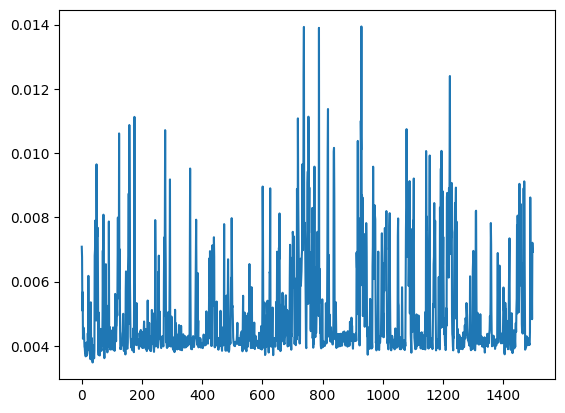

In [43]:
import matplotlib.pyplot as plt

plt.plot(times[1:])

In [44]:
import numpy as np


def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps


average_fps, std_dev_fps = calculate_fps_stats(times)

print("Average FPS:", average_fps)
print("Standard Deviation of FPS:", std_dev_fps)

Average FPS: 214.2562408895635
Standard Deviation of FPS: 45.280508404049094


In [19]:
import torch


def get_model_size(model_path):
    """
    Calculates the size of an ONNX model in bytes.

    Args:
        model_path (str): The path to the ONNX model file.

    Returns:
        int: The size of the model in bytes.
    """
    if ".onnx" in model_path:
        model = onnx.load(model_path)
        size_bytes = len(model.SerializeToString())
    elif ".pt" in model_path:
        model = torch.load(model_path)
        params = list(model.parameters())
        size_bytes = sum([p.numel() * p.element_size() for p in params])

    # Convert to KB, MB, GB, etc.
    if size_bytes < 1024:
        size_str = f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        size_str = f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024 * 1024 * 1024:
        size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size_str


get_model_size(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/resnet_fp16.onnx"
)

'46.16 MB'

In [15]:
import cv2


def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))*0.25
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))*0.25

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)


# Example usage:
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 150.0
Number of frames: 1500.0
Video length (seconds): 10.0
Frame size: (164.5, 75.5)
